In [9]:
import sqlite3
import pandas as pd
import os

# Adatbázis elérési útvonal
base_dir = os.path.dirname(os.path.abspath("__file__"))
db_path = os.path.join(base_dir, 'quiz_backend', 'db.sqlite3')

conn = sqlite3.connect(db_path)

In [10]:
df_questions = pd.read_sql_query("SELECT * FROM quiz_question", conn)
df_attempts = pd.read_sql_query("SELECT * FROM quiz_attempt", conn)
df_questions.head()

,id,text,option_a,option_b,option_c,correct_option,times_asked,times_correct,correct_answer,question_type,option_d
0,108,Mikor történt az első ember holdra lépése?,None,None,None,None,1,0,1969-07-20,DATE,None
1,109,Mikor kezdődött a II. világháború?,None,None,None,None,1,0,1939-09-01,DATE,None
2,110,Mikor ért véget a II. világháború?,None,None,None,None,2,0,1945-09-02,DATE,None
3,111,Mikor esett le a berlini fal?,None,None,None,None,0,0,1989-11-09,DATE,None
4,112,Mikor alapították az ENSZ-t?,None,None,None,None,1,0,1945-10-24,DATE,None


In [11]:
# Kérdéstípusonkénti statisztika:
df_questions['correct_rate'] = df_questions['times_correct'] / df_questions['times_asked']

# Előfordulhatnak NaN értékek, ha még sosem lett lekérdezve a kérdés (0-szor asked)
df_questions['correct_rate'] = df_questions['correct_rate'].fillna(0)

# Csoportosítás question_type szerint
stats_by_type = df_questions.groupby('question_type').agg({
    'times_asked': 'sum',
    'times_correct': 'sum',
    'correct_rate': 'mean'
})

print(stats_by_type)

               times_asked  times_correct  correct_rate
question_type                                          
DATE                    25              0           0.0
MC                      19             13           0.3
STRING                  26              0           0.0


In [12]:
df_attempts_per_user = df_attempts.groupby('username').agg({
    'score': ['count', 'sum', 'mean']
}).reset_index()

df_attempts_per_user.columns = ['username', 'quiz_count', 'total_score', 'avg_score']
df_attempts_per_user

,username,quiz_count,total_score,avg_score
0,Erik,16,640.52,40.032500
1,Józsi,5,500.00,100.000000
2,Kati,5,100.00,20.000000
3,Peti,37,1850.10,50.002703


In [13]:
df_attempts_question = df_attempts.groupby('question_id').agg({
    'score': ['count', 'mean']
}).reset_index()
df_attempts_question.columns = ['question_id', 'answer_count', 'avg_score']
df_attempts_question

,question_id,answer_count,avg_score
0,1,2,100.00
1,2,2,100.00
2,3,2,80.00
3,108,1,0.00
4,109,1,0.00
5,110,2,100.00
6,112,1,0.00
7,114,1,0.00
8,116,1,0.00
9,118,2,0.00


In [14]:
df_merged = df_attempts_question.merge(df_questions, left_on='question_id', right_on='id', how='left')
df_merged[['question_id', 'text', 'question_type', 'answer_count', 'avg_score']].head()

,question_id,text,question_type,answer_count,avg_score
0,1,NaN,NaN,2,100.0
1,2,NaN,NaN,2,100.0
2,3,NaN,NaN,2,80.0
3,108,Mikor történt az első ember holdra lépése?,DATE,1,0.0
4,109,Mikor kezdődött a II. világháború?,DATE,1,0.0


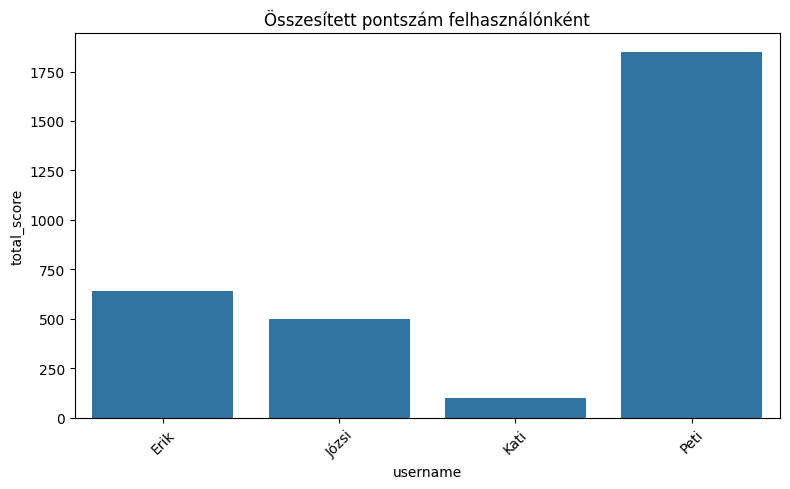

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Megnézzük, mekkora pontszámokat érnek el a játékosok (df_attempts_per_user alapján):
plt.figure(figsize=(8,5))
sns.barplot(data=df_attempts_per_user, x='username', y='total_score')
plt.title("Összesített pontszám felhasználónként")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

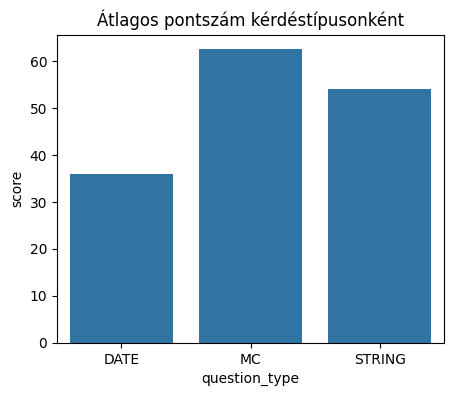

In [19]:
df_attempts_type = df_attempts.merge(df_questions[['id', 'question_type']],
                                     left_on='question_id', right_on='id',
                                     how='left')

df_type_score = df_attempts_type.groupby('question_type')['score'].mean().reset_index()

plt.figure(figsize=(5,4))
sns.barplot(data=df_type_score, x='question_type', y='score')
plt.title("Átlagos pontszám kérdéstípusonként")
plt.show()